In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
tf.keras.utils.set_random_seed(3)
from tqdm import tqdm
from tensorflow.keras.utils import plot_model
import time

In [2]:
import gc

# Data

In [3]:
BASE_PATH = ""#"/content/drive/MyDrive/Cursos/TFM_AI/TFM/aplicacion/"
train_path = BASE_PATH + "data/train.npz"
test_path = BASE_PATH + "data/test.npz"
classifier_path = BASE_PATH + "models/classifier.h5"
cvae_cgan_path = BASE_PATH + "models/cvae-cgan_no_noise.h5"

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
train_data = np.load(train_path)
X_train = train_data["arr_0"]
y_train = train_data["arr_1"]
X_train.shape, y_train.shape

((10000, 128, 128, 1), (10000,))

In [6]:
test_data = np.load(test_path)
X_test = test_data["arr_0"]
y_test = test_data["arr_1"]
X_test.shape, y_test.shape

((400, 128, 128, 1), (400,))

In [7]:
X_train = X_train / 255.
X_test = X_test / 255.

# Classifier

In [8]:
images_shape = X_test.shape[1:]
images_shape

(128, 128, 1)

In [9]:
base_model = keras.applications.ResNet50V2(input_shape=(128,128,3), include_top=False)

In [10]:
classifier_inputs = keras.Input(shape=images_shape)
x = layers.Conv2D(3, (3,3), activation="relu", padding="same")(classifier_inputs)
x = base_model(x)
x = layers.GlobalMaxPool2D()(x)

x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01))(x)

classifier_output = layers.Dense(1, activation="sigmoid")(x)

classifier = keras.Model(classifier_inputs, classifier_output)
classifier.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.001), metrics=['accuracy'])
classifier.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 3)       30        
                                                                 
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                             

In [11]:
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.1, patience=15, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

In [12]:
gc.collect()
keras.backend.clear_session()

In [13]:
init_time = time.time()
logs = classifier.fit(X_train, y_train, epochs=30, batch_size=32, 
               validation_split=0.1, 
               callbacks=[early_stop, reduce_lr]) 
print(f"Total time: {time.time() - init_time} (s)")

Epoch 1/30
282/282 [==============================] - 29s 79ms/step - loss: 3.5062 - accuracy: 0.8406 - val_loss: 1.7849 - val_accuracy: 0.8870 - lr: 0.0010
Epoch 2/30
282/282 [==============================] - 21s 76ms/step - loss: 1.0161 - accuracy: 0.9330 - val_loss: 0.9400 - val_accuracy: 0.7590 - lr: 0.0010
Epoch 3/30
282/282 [==============================] - 22s 78ms/step - loss: 0.4160 - accuracy: 0.9481 - val_loss: 3.6014 - val_accuracy: 0.5040 - lr: 0.0010
Epoch 4/30
282/282 [==============================] - 22s 78ms/step - loss: 0.3690 - accuracy: 0.9171 - val_loss: 2.0134 - val_accuracy: 0.6820 - lr: 0.0010
Epoch 5/30
282/282 [==============================] - 23s 81ms/step - loss: 0.1979 - accuracy: 0.9467 - val_loss: 0.9838 - val_accuracy: 0.6940 - lr: 0.0010
Epoch 6/30
282/282 [==============================] - 22s 78ms/step - loss: 0.1675 - accuracy: 0.9536 - val_loss: 0.7163 - val_accuracy: 0.7180 - lr: 0.0010
Epoch 7/30
282/282 [==============================] - 22s 

In [14]:
classifier.evaluate(X_test, y_test)

13/13 [==============================] - 0s 28ms/step - loss: 0.2476 - accuracy: 0.9175


[0.2476484626531601, 0.9175000190734863]

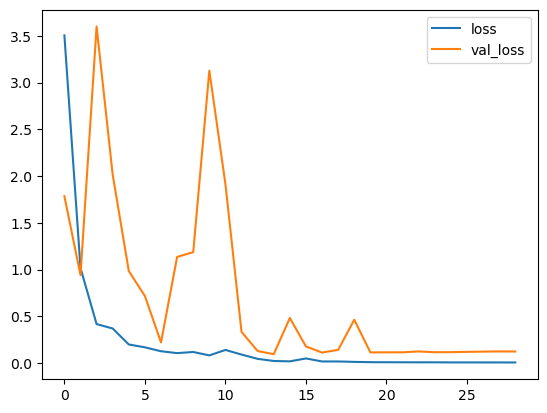

In [15]:
plt.plot(logs.history['loss'], label="loss")
plt.plot(logs.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

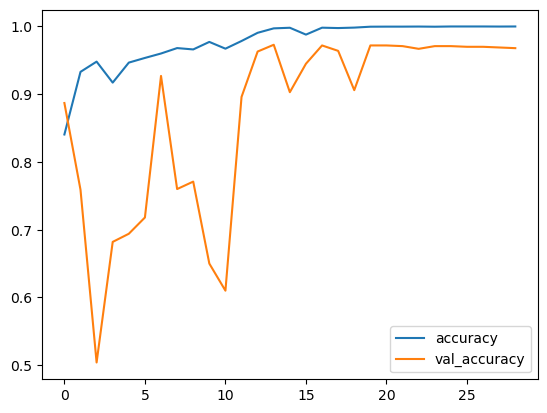

In [16]:
plt.plot(logs.history['accuracy'], label="accuracy")
plt.plot(logs.history['val_accuracy'], label="val_accuracy")
plt.legend()
plt.show()

In [17]:
classifier.save(classifier_path) 